# 00. 라이브러리

In [142]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [143]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

# 01. 데이터 준비

In [144]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 02. Data_loader

In [145]:
# 토크나이저 정의
tokenizer = Mecab()

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 특수 토큰 정의
pad_token = '<PAD>'
bos_token = '<BOS>'
unk_token = '<UNK>'
eos_token = '<EOS>'

def load_data(train_data, test_data, num_words=10000):
    
    # 중복 단어 제거    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 결측치 처리
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    # 불용어 제거 (토큰화 -> 불용어 제거)
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 리스트 생성 및 빈도수 계산
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)

    # 어휘 사전 생성
    vocab = [pad_token, bos_token, unk_token, eos_token] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}
    
    # 단어 인덱스 -> 인덱스 리스트 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index.get(word, word_to_index[unk_token]) for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [146]:
# word to index 에서 index to word로 변환
index_to_word = {index:word for word, index in word_to_index.items()}

In [147]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [148]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [149]:
# 패딩 적용
maxlen = 45  # 최대 시퀀스 길이 설정
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train,
    value=word_to_index[pad_token],
    padding='pre',
    maxlen=maxlen
)
X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test,
    value=word_to_index[pad_token],
    padding='pre',
    maxlen=maxlen
)

In [150]:
X_train.shape

(146182, 45)

# 03. 모델 정의

In [151]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 14  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(16, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 14)          140000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                1984      
_________________________________________________________________
dense_54 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_55 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 9         
Total params: 142,401
Trainable params: 142,401
Non-trainable params: 0
_________________________________________________________________


In [152]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 14   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_1d = tf.keras.Sequential()
model_1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1d.add(tf.keras.layers.Conv1D(128, 10, activation='relu'))
model_1d.add(tf.keras.layers.MaxPooling1D(2))
model_1d.add(tf.keras.layers.Conv1D(64, 10, activation='relu'))
model_1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_1d.add(tf.keras.layers.Dense(16, activation='relu'))
model_1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1d.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 14)          140000    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 128)         18048     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, None, 64)          81984     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_58 (Dense)             (None, 8)               

In [96]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 14   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(32, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(16, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 14)          140000    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 14)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
Total params: 141,025
Trainable params: 141,025
Non-trainable params: 0
_________________________________________________________________


# 04. 모델 평가

In [153]:
# validation set 분리
from sklearn.model_selection import train_test_split

X_train,X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2)

In [154]:
# 모델 실행 및 모델 평가 함수화 - 귀찮으니 함수화 해버리자..

def model_evaluate(model, x_train, y_train, x_val, y_val,x_test,y_test,epochs,batch_size):
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)
    results = model.evaluate(x_test, y_test, verbose=2)
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))

    # 첫 번째 subplot: Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')    # 'bo'는 파란색 점
    plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b'는 파란 실선
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 두 번째 subplot: Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'ro', label='Training acc')      # 'ro'는 빨간색 점
    plt.plot(epochs, val_acc, 'r', label='Validation acc')   # 'r'는 빨간 실선
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return results, history_dict

Epoch 1/20
914/914 [==============================] - 7s 6ms/step - loss: 0.4091 - accuracy: 0.8165 - val_loss: 0.3537 - val_accuracy: 0.8444
Epoch 2/20
914/914 [==============================] - 5s 6ms/step - loss: 0.3295 - accuracy: 0.8593 - val_loss: 0.3490 - val_accuracy: 0.8464
Epoch 3/20
914/914 [==============================] - 5s 6ms/step - loss: 0.3064 - accuracy: 0.8706 - val_loss: 0.3462 - val_accuracy: 0.8480
Epoch 4/20
914/914 [==============================] - 5s 6ms/step - loss: 0.2866 - accuracy: 0.8801 - val_loss: 0.3452 - val_accuracy: 0.8489
Epoch 5/20
914/914 [==============================] - 5s 6ms/step - loss: 0.2630 - accuracy: 0.8906 - val_loss: 0.3526 - val_accuracy: 0.8519
Epoch 6/20
914/914 [==============================] - 5s 6ms/step - loss: 0.2413 - accuracy: 0.9006 - val_loss: 0.3550 - val_accuracy: 0.8495
Epoch 7/20
914/914 [==============================] - 5s 6ms/step - loss: 0.2213 - accuracy: 0.9097 - val_loss: 0.3712 - val_accuracy: 0.8502
Epoch 

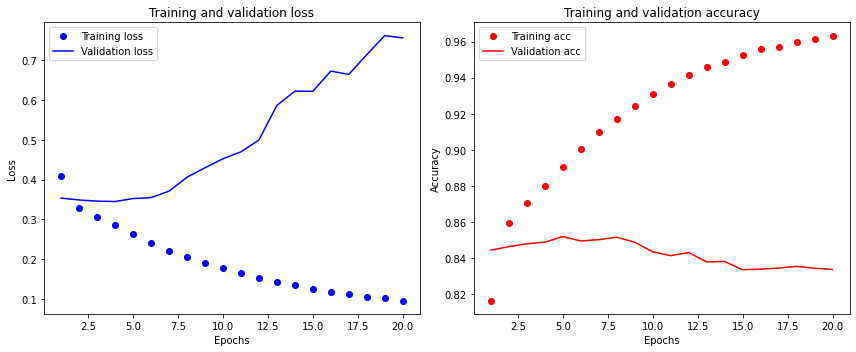

In [155]:
results_lstm, history_dict_lstm = model_evaluate(model_lstm, X_train,y_train, X_val, y_val,X_test,y_test,20,128)

Epoch 1/20
229/229 [==============================] - 3s 8ms/step - loss: 0.4617 - accuracy: 0.7620 - val_loss: 0.3576 - val_accuracy: 0.8419
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3262 - accuracy: 0.8605 - val_loss: 0.3485 - val_accuracy: 0.8480
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2928 - accuracy: 0.8767 - val_loss: 0.3464 - val_accuracy: 0.8496
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2636 - accuracy: 0.8917 - val_loss: 0.3509 - val_accuracy: 0.8486
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2328 - accuracy: 0.9067 - val_loss: 0.3656 - val_accuracy: 0.8462
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2005 - accuracy: 0.9225 - val_loss: 0.3985 - val_accuracy: 0.8439
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1685 - accuracy: 0.9370 - val_loss: 0.4327 - val_accuracy: 0.8417
Epoch 

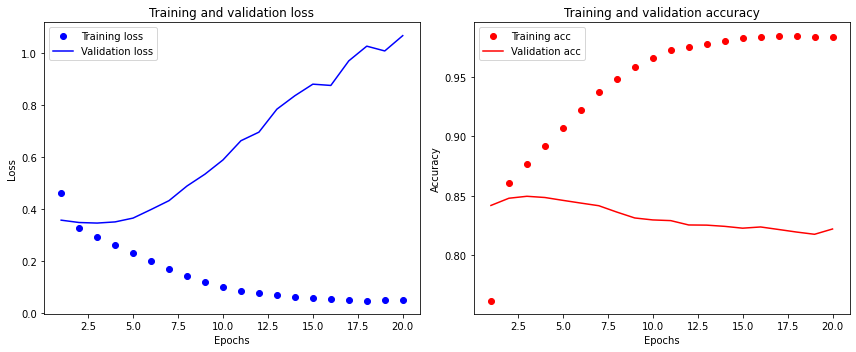

In [156]:
results_1d, history_dict_1d = model_evaluate(model_1d, X_train,y_train, X_val, y_val,X_test,y_test,20,512)

Epoch 1/20
914/914 [==============================] - 4s 4ms/step - loss: 0.2619 - accuracy: 0.9046 - val_loss: 0.2623 - val_accuracy: 0.8988
Epoch 2/20
914/914 [==============================] - 3s 4ms/step - loss: 0.2335 - accuracy: 0.9140 - val_loss: 0.2782 - val_accuracy: 0.8885
Epoch 3/20
914/914 [==============================] - 3s 4ms/step - loss: 0.2149 - accuracy: 0.9224 - val_loss: 0.2947 - val_accuracy: 0.8833
Epoch 4/20
914/914 [==============================] - 3s 4ms/step - loss: 0.1994 - accuracy: 0.9294 - val_loss: 0.3149 - val_accuracy: 0.8779
Epoch 5/20
914/914 [==============================] - 3s 4ms/step - loss: 0.1858 - accuracy: 0.9350 - val_loss: 0.3321 - val_accuracy: 0.8722
Epoch 6/20
914/914 [==============================] - 3s 4ms/step - loss: 0.1750 - accuracy: 0.9389 - val_loss: 0.3538 - val_accuracy: 0.8691
Epoch 7/20
914/914 [==============================] - 3s 4ms/step - loss: 0.1657 - accuracy: 0.9426 - val_loss: 0.3600 - val_accuracy: 0.8674
Epoch 

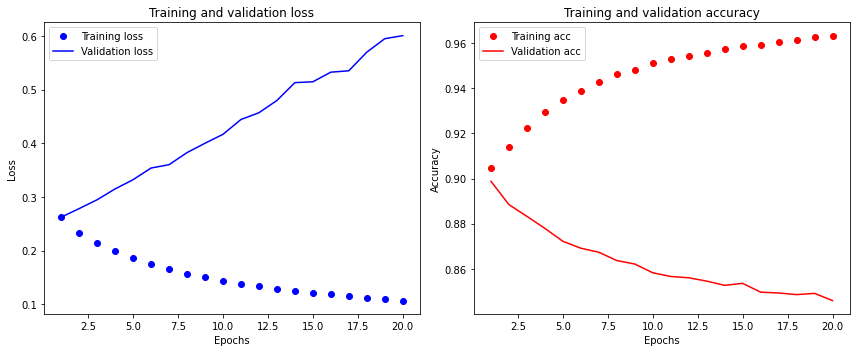

In [157]:
results_gmp, history_dict_gmp = model_evaluate(model_gmp, X_train,y_train, X_val, y_val,X_test,y_test,20,128)

# 05. 학습된 임베딩 모델 활용 및 분석

In [158]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

# Word2Vec 모델 로드
model_path = os.path.expanduser('~/data/word2vec_ko.model')
word_vectors = Word2VecKeyedVectors.load(model_path )

# 모델 활용 예시
vector = word_vectors.wv['끝']

In [159]:
# 벡터 크기 분석 및 레이어 확인
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [160]:
# 단어 임베딩 가중치 가져오기 - shape를 통한 학습된 임베딩 크기 분석
weights = word_vectors.wv.vectors
print(weights.shape)  # shape: (vocab_size, embedding_dim)

(302960, 100)


In [161]:
vocab_size = 10000    # 어휘 사전의 크기입니다(302960개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [182]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어만 사용... 나의 실수 단어가 300000개 인데;;)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(256, 8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(128, 8, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 45, 100)           1000000   
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 38, 256)           205056    
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 19, 256)           0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 12, 128)           262272    
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_75 (Dense)             (None, 32)              

Epoch 1/5
7310/7310 [==============================] - 39s 5ms/step - loss: 0.4370 - accuracy: 0.7951 - val_loss: 0.3698 - val_accuracy: 0.8359
Epoch 2/5
7310/7310 [==============================] - 37s 5ms/step - loss: 0.3298 - accuracy: 0.8582 - val_loss: 0.3342 - val_accuracy: 0.8509
Epoch 3/5
7310/7310 [==============================] - 38s 5ms/step - loss: 0.2841 - accuracy: 0.8797 - val_loss: 0.3692 - val_accuracy: 0.8472
Epoch 4/5
7310/7310 [==============================] - 37s 5ms/step - loss: 0.2442 - accuracy: 0.8991 - val_loss: 0.3385 - val_accuracy: 0.8548
Epoch 5/5
7310/7310 [==============================] - 37s 5ms/step - loss: 0.2030 - accuracy: 0.9182 - val_loss: 0.3748 - val_accuracy: 0.8553
1537/1537 - 3s - loss: 0.3789 - accuracy: 0.8510


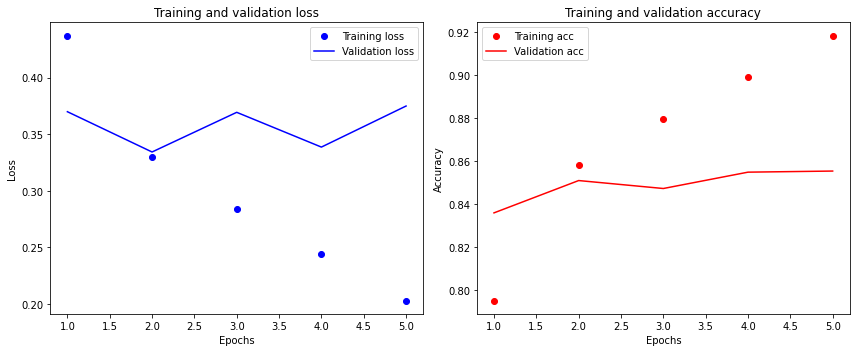

In [183]:
# 학습 진행
results, history_dict = model_evaluate(model, X_train,y_train, X_val, y_val,X_test,y_test,5,16)

In [184]:
# 테스트셋을 통한 모델 평가
print(results)

# 결과 겨우겨우 0.851...달성 휴..

[0.3789288103580475, 0.851028323173523]


## 회고

###  NLP 의 어려움을 다시 한번 느꼈다. 비정형 데이터를 가져와 토큰화, 임베딩 처리에서의 중요성이 강조되는 프로젝트였다고 생각된다.  추가적으로 해보고 싶은 실험들은 너무 많았다.
#### 1. 기존 임베딩 된 모델의 vocap_size를 늘려서 진행해보는 과정 10000 -> 300000개  임베딩된 단어의 집합이 늘수록 텍스트 데이터에 대한 풍부한 학습과 결과 도출이 가능하다고 판단되기 때문
#### 2. 감성 분석에 특화된 임베딩 모델을 가져와 수행해보기 이 역시 위의 이유와 같다.

#### 모델 평가 후 결과에 대한 아쉬움이 많이 남는다...이유는 임베딩된 모델 중 단어의 집합을 10000개 가져와 진행하였기 때문으로 판단된다. 따라서 모델의 깊이를 비효율적으로 늘린 경우의 코드라고 생각된다. 그러나 모델이 깊을 수록 학습 능력의 한계가 있음을 확인할 수 있는 결과였기도 하다.  그러나.. 내일이 너무 걱정된다.. 잘할 수 있을까?